# Understanding the Problem and Data



Solar irradiance is the power per unit area received from the Sun in the form of electromagnetic radiation as reported in the wavelength range of the measuring instrument. The solar irradiance is measured in watt per square metre (W/m2) in SI units. Solar irradiance is often integrated over a given time period in order to report the radiant energy emitted into the surrounding environment (joule per square metre, J/m2) during that time period. This integrated solar irradiance is called solar irradiation, solar exposure, solar insolation, or insolation.


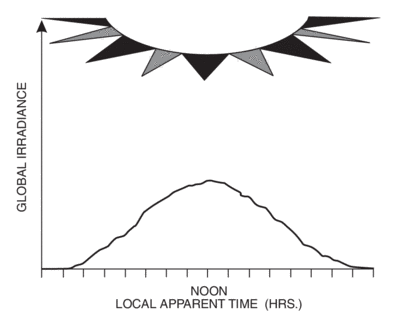

The dataset includes observations of:

Solar Irradiance (W/m2)

Temperature (°F)

Barometric Pressure (Hg)

Humidity (%)

Wind Direction (°)

Wind Speed (mph)

Sun Rise/Set Time

it contains measurements for the 4 months (2016-09-01 to 2016-12-31) [Pacific/Honolulu] and you have to predict the level of solar radiation.

Machine Learning using Solar radiation prediction Dataset

1.Dataset: Solar radiation prediction

2.Problem statement:  Prediction of solar radiation

3.Type of problem: Regression, Supervised

4.Data type: values

5.Performance Measures: Accuracy, Precision, Recall, Confusion Matrix

6.Feature Importance: Not required


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
data = pd.read_csv('C:/Users/Hrushi/Desktop/python/SolarPrediction.csv')

print(data.shape)
data.head()

(32686, 11)


,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [3]:
#Checking which data is available in the dataset and which data-type is associated to each column of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


In [4]:
#Checking if there are missing values
data.isna().sum()

UNIXTime                  0
Data                      0
Time                      0
Radiation                 0
Temperature               0
Pressure                  0
Humidity                  0
WindDirection(Degrees)    0
Speed                     0
TimeSunRise               0
TimeSunSet                0
dtype: int64

A preliminary analysis of the dataset indicates that there are no missing values, and therefore there is no need to understand how to deal with potential missing records.

It is possible to notice, however, that some features are not represented by the right class: the various dates are included as "objects", and hence they should be converted to "datetime" objects to facilitate their handling during the study.

As a first step, the UNIXTime is converted into a datetime object, and the right timezone is allocated to this feature (when converting UNIX time to datetime, the UTC timezone is assumed, and there is therefore the need to update this info, because the data is collected under the HST timezone).

In [5]:
#Converting UNIX time to datetime object
data['Date']= pd.to_datetime(data['UNIXTime'],unit='s')

#Setting the right timezone to the datetime object
data['Date'] = data['Date'].dt.tz_localize('UTC').dt.tz_convert('HST')

As a second step, the SunRiseTime and SunSetTime columns are adjusted. These columns only contain information about the sunrise and sunset time, while it would be beneficial to have them containing both the time and the date.

In order to update this columns, it is possible to proceed as follows:

1.Convert the "SunRiseTime" and "SunSetTime" columns into a datetime.time object

2.Convert the "Data" column into a datetime.date object

3.Combine the datetime.time and datetime.date objects through the function pd.datetime.combine()
After doing so, similarly to what done previously, the correct timezone is allocated to the data.

In [6]:
#Extracting date from Data column
data['Data'] = pd.to_datetime(data['Data']).dt.date

#Converting Sunrise and Sunset columns into datetime.time objects
data['TimeSunRise'] = pd.to_datetime(data['TimeSunRise']).dt.time
data['TimeSunSet'] = pd.to_datetime(data['TimeSunSet']).dt.time

#Creating new sunset/sunrise columns featuring also the right date
data['sunrise_time'] = data.apply(lambda row: pd.datetime.combine(row['Data'], row['TimeSunRise']), axis = 1)
data['sunset_time'] = data.apply(lambda row: pd.datetime.combine(row['Data'], row['TimeSunSet']), axis = 1)

#Adding approriate timezone
data['sunrise_time'] = data['sunrise_time'].dt.tz_localize('HST')
data['sunset_time'] = data['sunset_time'].dt.tz_localize('HST')

<ipython-input-6-13dc48d04326>:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  data['sunrise_time'] = data.apply(lambda row: pd.datetime.combine(row['Data'], row['TimeSunRise']), axis = 1)
<ipython-input-6-13dc48d04326>:10: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  data['sunset_time'] = data.apply(lambda row: pd.datetime.combine(row['Data'], row['TimeSunSet']), axis = 1)


Now that the date columns have been correctly identified as datetime objects, it is suitable to set the newly created "Date" column as index, sort the data by the index (ascending order), and drop the non-required columns.

In [7]:
#Setting 'Date' as index
data.set_index('Date', inplace = True)

#Sorting by the index
data.sort_index()

data.drop(columns = ['Data', 'Time', 'TimeSunRise',
                    'TimeSunSet'], inplace = True)

In [8]:
#Inspecting the first rows of the dataset
data.head()

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,sunrise_time,sunset_time
Date,,,,,,,,,
2016-09-29 23:55:26-10:00,1475229326,1.21,48,30.46,59,177.39,5.62,2016-09-29 06:13:00-10:00,2016-09-29 18:13:00-10:00
2016-09-29 23:50:23-10:00,1475229023,1.21,48,30.46,58,176.78,3.37,2016-09-29 06:13:00-10:00,2016-09-29 18:13:00-10:00
2016-09-29 23:45:26-10:00,1475228726,1.23,48,30.46,57,158.75,3.37,2016-09-29 06:13:00-10:00,2016-09-29 18:13:00-10:00
2016-09-29 23:40:21-10:00,1475228421,1.21,48,30.46,60,137.71,3.37,2016-09-29 06:13:00-10:00,2016-09-29 18:13:00-10:00
2016-09-29 23:35:24-10:00,1475228124,1.17,48,30.46,62,104.95,5.62,2016-09-29 06:13:00-10:00,2016-09-29 18:13:00-10:00


If the data handling has been carried out correctly, then it would be reasonable to expect that the solar radiation, for any considered day, would be approximately zero before the sunrise time, and after the sunset time. It is possible to check this by means of a graphical inspection.

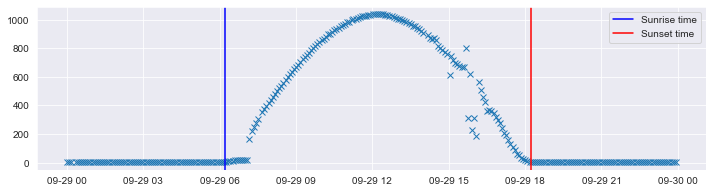

In [9]:
data_one_day = data.loc['2016-09-29':'2016-09-30',:]

plt.figure(figsize = (12,3))
plt.plot(data_one_day.Radiation, 'x', markerfacecolor = 'w')

#Plotting vertical line at sunrise
plt.axvline(data_one_day.sunrise_time.iloc[0], label = 'Sunrise time', color = 'blue')

#Plotting vertical line at sunset
plt.axvline(data_one_day.sunset_time.iloc[0], label = 'Sunset time', color = 'red') 

#Adjusting timezone of x-axis
plt.gca().xaxis_date('HST')

plt.legend()
plt.show()

# Preliminary Data Analysis

The objective of the preliminary data analysis is to get a sense of how the data looks like, and to confirm whether the data actually makes sense (i.e. it would be questionable to identify negative values for the Solar radiation).

The first step of the preliminary data analysis is therefore to check the ranges of the various features of the dataset, and to do a cross-check whether these ranges are reasonable.

In [10]:
#Analysing the ranges of the various features of the datset
data.describe()

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
count,3.268600e+04,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,1.478047e+09,207.124697,51.103255,30.422879,75.016307,143.489821,6.243869
std,3.005037e+06,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474
min,1.472724e+09,1.110000,34.000000,30.190000,8.000000,0.090000,0.000000
25%,1.475546e+09,1.230000,46.000000,30.400000,56.000000,82.227500,3.370000
50%,1.478026e+09,2.660000,50.000000,30.430000,85.000000,147.700000,5.620000
75%,1.480480e+09,354.235000,55.000000,30.460000,97.000000,179.310000,7.870000
max,1.483265e+09,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000


As a second step of the preliminary data analysis, it is reasonable to check for the distribution of the data, in order to understand how the various data is allocated between the lower and upper limits. This can be carried out by plotting either a distribution plot or a boxplot.

Both are plotted in this case, as they enable to have a more comprehensive understanding of the data.

C:\Users\Hrushi\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Hrushi\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Hrushi\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-

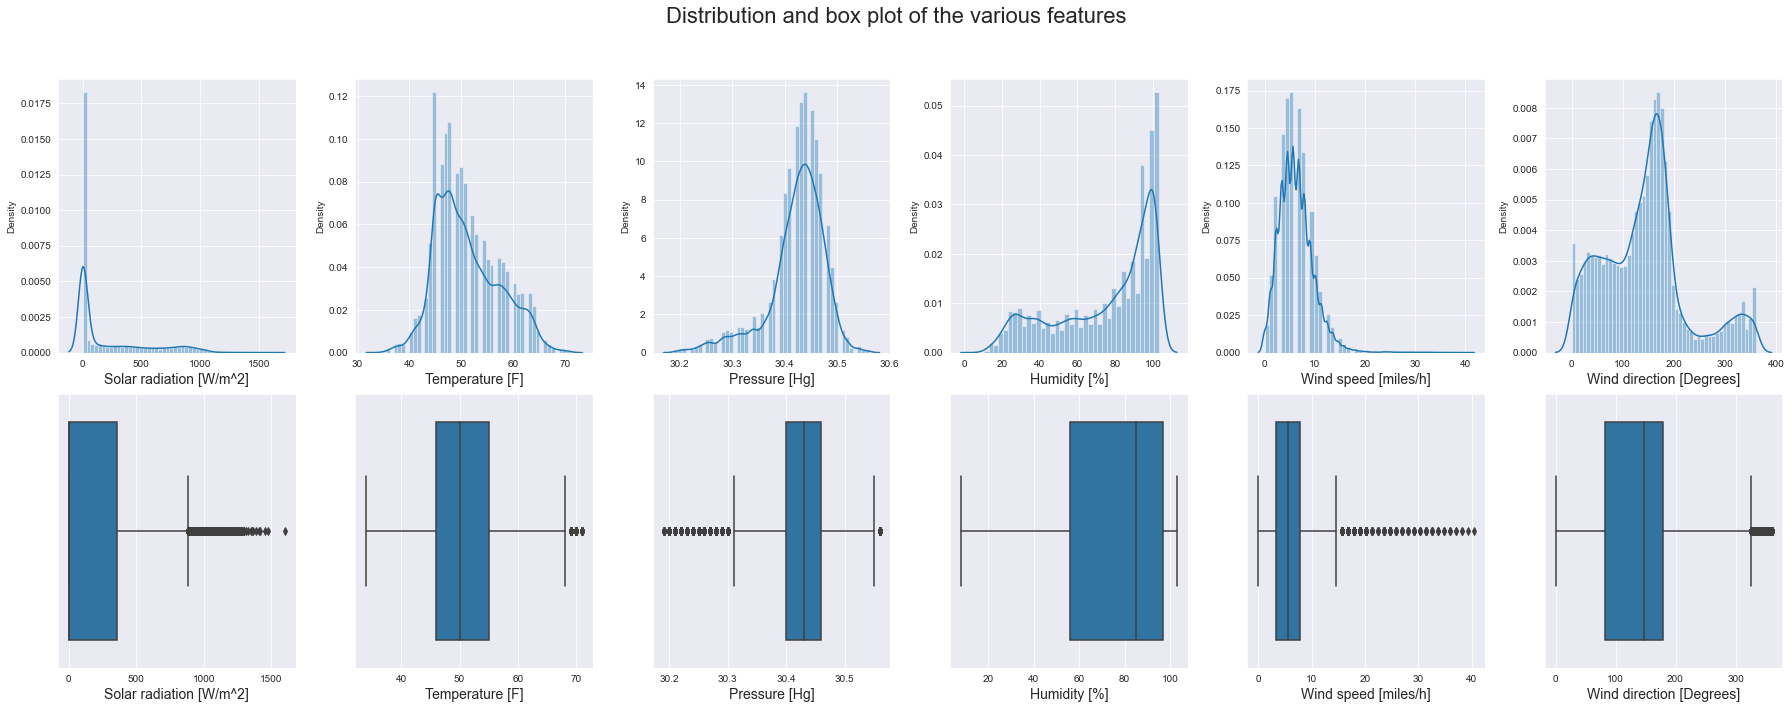

In [11]:
fig, ax = plt.subplots(nrows =2, ncols = 6, figsize = (25, 10))

sns.distplot(data.Radiation, ax = ax[0,0])
ax[0,0].set_xlabel('Solar radiation [W/m^2]', fontsize = 14)

sns.distplot(data.Temperature, ax = ax[0,1])
ax[0,1].set_xlabel('Temperature [F]', fontsize = 14)

sns.distplot(data.Pressure, ax = ax[0,2])
ax[0,2].set_xlabel('Pressure [Hg]', fontsize = 14)

sns.distplot(data.Humidity, ax = ax[0,3])
ax[0,3].set_xlabel('Humidity [%]', fontsize = 14)

sns.distplot(data.Speed, ax = ax[0,4])
ax[0,4].set_xlabel('Wind speed [miles/h]', fontsize = 14)

sns.distplot(data['WindDirection(Degrees)'], ax = ax[0,5])
ax[0,5].set_xlabel('Wind direction [Degrees]', fontsize = 14)


sns.boxplot(data.Radiation, ax = ax[1,0])
ax[1,0].set_xlabel('Solar radiation [W/m^2]', fontsize = 14)

sns.boxplot(data.Temperature, ax = ax[1,1])
ax[1,1].set_xlabel('Temperature [F]', fontsize = 14)

sns.boxplot(data.Pressure, ax = ax[1,2])
ax[1,2].set_xlabel('Pressure [Hg]', fontsize = 14)

sns.boxplot(data.Humidity, ax = ax[1,3])
ax[1,3].set_xlabel('Humidity [%]', fontsize = 14)

sns.boxplot(data.Speed, ax = ax[1,4])
ax[1,4].set_xlabel('Wind speed [miles/h]', fontsize = 14)

sns.boxplot(data['WindDirection(Degrees)'], ax = ax[1,5])
ax[1,5].set_xlabel('Wind direction [Degrees]', fontsize = 14)

fig.suptitle('Distribution and box plot of the various features', fontsize = 22)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

plt.show()

Looking at the distribution of the data it is possible to conclude that most features have a skewed distribution, except for the wind directions, which is characterized by three peaks.

As it was possible to assume, roughtly 50 % of values of the solar radiation are located in the range between 0 W/^2 and 250 W/m^2 (there is no or little solar radiation at night). With respect to the wind speed, it seems that the high wind speeds areextreme outliers in a distribution that has most of its values in the range between 0 miles/h and 20 miles/h.

As a last step in the preliminary data analysis, it makes good sense to plot the data for limited range of time. In this case, a five-day period is selected.
Plotting the data enables to have an understanding regarding the variability of data itself during the day, which could provide some interesting insights to be accounted for when proceeding with the building of a ML model to predict the solar radiation.

Aside from the data, also the hourly-median of the data is represented in the following plots. This allows for an easier identification of potential patterns. The median is selected over the mean, because it is less affected by the presence of potential outliers.

In [12]:
#Creation of the median dataset
data_median = data.resample('H').median().dropna()

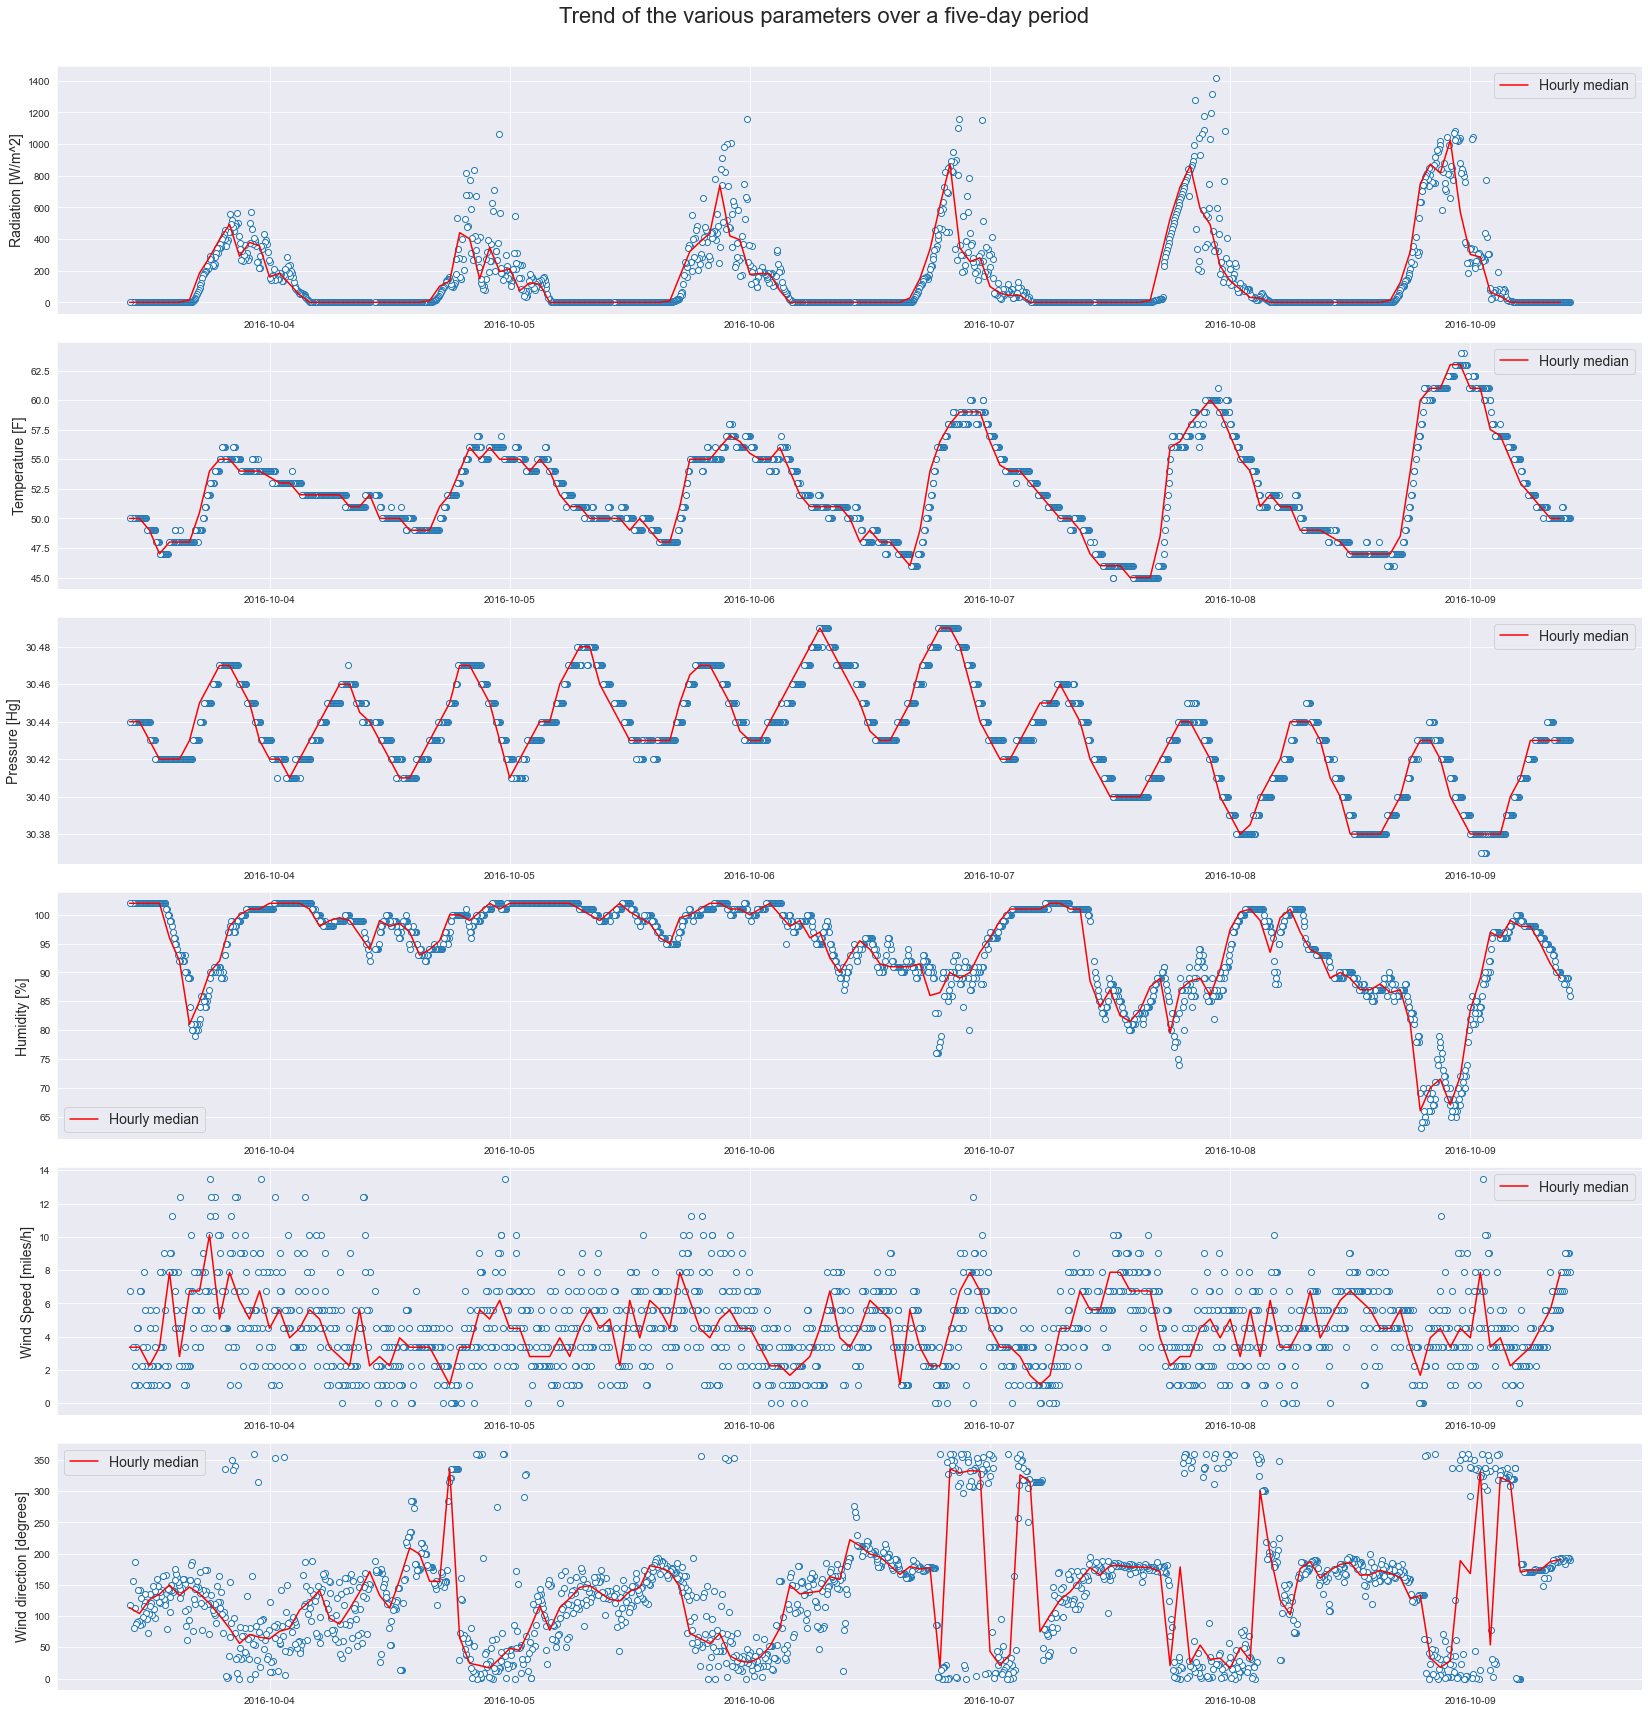

In [13]:
#Extraction of the data for a five-day period
data_5 = data.loc['2016-10-03':'2016-10-08',:]
data_5_median = data_median.loc['2016-10-03':'2016-10-08',:]


fig, ax = plt.subplots(nrows =6, ncols = 1, figsize = (23,25))

ax[0].plot(data_5.Radiation,'o', markerfacecolor='w')
ax[0].plot(data_5_median.Radiation, linewidth = 1.5, color = 'red', label = 'Hourly median')
ax[0].set_ylabel('Radiation [W/m^2]', fontsize = 14)
ax[0].legend(fontsize = 14)

ax[1].plot(data_5.Temperature,'o', markerfacecolor='w')
ax[1].plot(data_5_median.Temperature, linewidth = 1.5, color = 'red', label = 'Hourly median')
ax[1].set_ylabel('Temperature [F]', fontsize = 14)
ax[1].legend(fontsize = 14)

ax[2].plot(data_5.Pressure,'o', markerfacecolor='w')
ax[2].plot(data_5_median.Pressure, linewidth = 1.5, color = 'red', label = 'Hourly median')
ax[2].set_ylabel('Pressure [Hg]', fontsize = 14)
ax[2].legend(fontsize = 14)

ax[3].plot(data_5.Humidity,'o', markerfacecolor='w')
ax[3].plot(data_5_median.Humidity, linewidth = 1.5, color = 'red', label = 'Hourly median')
ax[3].set_ylabel('Humidity [%]', fontsize = 14)
ax[3].legend(fontsize = 14)

ax[4].plot(data_5.Speed,'o', markerfacecolor='w')
ax[4].plot(data_5_median.Speed, linewidth = 1.5, color = 'red', label = 'Hourly median')
ax[4].set_ylabel('Wind Speed [miles/h]', fontsize = 14)
ax[4].legend(fontsize = 14)

ax[5].plot(data_5['WindDirection(Degrees)'],'o', markerfacecolor='w')
ax[5].plot(data_5_median['WindDirection(Degrees)'], linewidth = 1.5, color = 'red', label = 'Hourly median')
ax[5].set_ylabel('Wind direction [degrees]', fontsize = 14)
ax[5].legend(fontsize = 14)

fig.suptitle('Trend of the various parameters over a five-day period', fontsize = 22)
fig.tight_layout(rect=[0, 0.03, 1, 0.97])

plt.show()

# 

# Correlation Matrix

Now that all the features have been defined and included in the dataset, it is time to identify if there are clear patterns between the features and the target parameter. One way to do so is to plot the correlation matrix, which displays whether there is a linear correlation between the various variables.

A value close to 1 indicates a strongly linear positive correlation, while a value close to -1 indicates a strongly negative linear correlation.

Values around zero indicate that there is no linear correlation, but do not exclude that other kind of correlations are present (i.e. exponential, more than linear, quadratic, etc..)

In [16]:
from datetime import datetime
#Converting sunrise and sunset times into timestamp
data['sunrise_timestamp'] = data.apply(lambda row: datetime.timestamp(row['sunrise_time']), axis = 1)
data['sunset_timestamp'] = data.apply(lambda row: datetime.timestamp(row['sunset_time']), axis = 1)

#Creating a column containing the number of daily light hours
data['Hours_of_light'] = (data['sunset_timestamp'] - data['sunrise_timestamp'])/60/60

#Creating column describing current time relative to sunrise/sunset
data['Rel_time'] = (data['UNIXTime']- data['sunrise_timestamp'])/(data['sunset_timestamp']-data['sunrise_timestamp'])

In [17]:
#Removing non-necessary columns
data.drop(columns = ['UNIXTime','sunrise_timestamp', 'sunset_timestamp', 
                     'sunset_time', 'sunrise_time'], inplace = True)

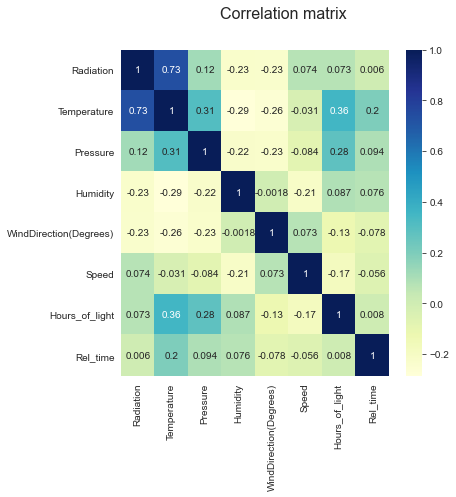

In [18]:
#Plotting a heatmap of the various features in the dataset
fig, ax = plt.subplots(figsize = (6,6))
sns.heatmap(data.corr(), annot = True, cmap = 'YlGnBu')
fig.suptitle('Correlation matrix', fontsize = 16)
plt.show()

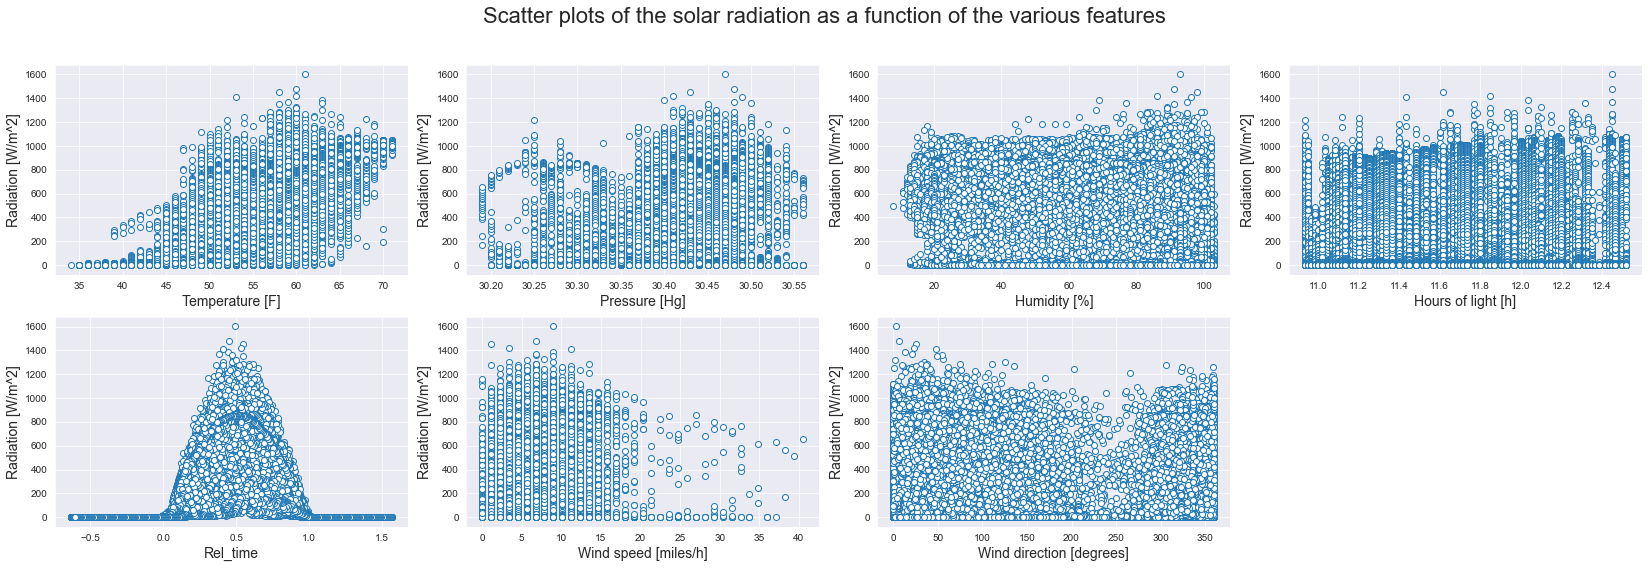

In [19]:
fig, ax = plt.subplots(nrows =2, ncols = 4, figsize = (23,8))

ax[0,0].plot(data.Temperature, data.Radiation,'o', markerfacecolor='w')
ax[0,0].set_xlabel('Temperature [F]', fontsize = 14)
ax[0,0].set_ylabel('Radiation [W/m^2]', fontsize = 14)

ax[0,1].plot(data.Pressure, data.Radiation,'o', markerfacecolor='w')
ax[0,1].set_xlabel('Pressure [Hg]', fontsize = 14)
ax[0,1].set_ylabel('Radiation [W/m^2]', fontsize = 14)

ax[0,2].plot(data.Humidity, data.Radiation,'o', markerfacecolor='w')
ax[0,2].set_xlabel('Humidity [%]', fontsize = 14)
ax[0,2].set_ylabel('Radiation [W/m^2]', fontsize = 14)

ax[0,3].plot(data.Hours_of_light, data.Radiation,'o', markerfacecolor='w')
ax[0,3].set_xlabel('Hours of light [h]', fontsize = 14)
ax[0,3].set_ylabel('Radiation [W/m^2]', fontsize = 14)

ax[1,0].plot(data.Rel_time, data.Radiation,'o', markerfacecolor='w')
ax[1,0].set_xlabel('Rel_time', fontsize = 14)
ax[1,0].set_ylabel('Radiation [W/m^2]', fontsize = 14)

ax[1,1].plot(data.Speed, data.Radiation,'o', markerfacecolor='w')
ax[1,1].set_xlabel('Wind speed [miles/h]', fontsize = 14)
ax[1,1].set_ylabel('Radiation [W/m^2]', fontsize = 14)

ax[1,2].plot(data['WindDirection(Degrees)'], data.Radiation,'o', markerfacecolor='w')
ax[1,2].set_xlabel('Wind direction [degrees]', fontsize = 14)
ax[1,2].set_ylabel('Radiation [W/m^2]', fontsize = 14)

fig.delaxes(ax[1,3])

fig.suptitle('Scatter plots of the solar radiation as a function of the various features', fontsize = 22)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

plt.show()

# Prediction of the solar radiation with a linear model
The preliminary investigations indicated that the solar radiation is related to the various features in a non-linear way (except for the ambient temperature). It is however interesting to check how the use of a linear model will perform in this setting. In addition, the performance of the linear model can be used as a benchmark when considering more complex ML models.

In order to train a linear ML model, the dateset is divided into features (X) and the variable to be predicted (y = Solar radiation) and then split into train and test sets. Splitting the data into train and test sets enables to check the accuracy of the ML model when predicting non-previously seen data.

In [20]:
#Renaming dataset
df = data

#Splitting dataset into labels and features
X = df.drop(columns = 'Radiation')
y = df.Radiation

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
#Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                   test_size = 0.3,
                                                   random_state = 42)

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

In [24]:
#Initiating linear regression model
lr = LinearRegression()

#Training the linear regression model
lr.fit(X_train, y_train)

#Carrying out prediction with the linear model
lr_predict_train = lr.predict(X_train)
lr_predict_test = lr.predict(X_test)

In [25]:
#Checking the performance of the linear model

#Squared error
print('Linear model, R^2 training set:{:.2f}'.format(r2_score(y_train, lr_predict_train)))
print('Linear model, R^2 test set:{:.2f}'.format(r2_score(y_test,lr_predict_test)))

#Mean squared error (MSE)
print('Linear model, MSE training set:{:.2f}'.format(MSE(y_train, lr_predict_train)))
print('Linear model, MSE test set:{:.2f}'.format(MSE(y_test,lr_predict_test)))

Linear model, R^2 training set:0.62
Linear model, R^2 test set:0.61
Linear model, MSE training set:37816.47
Linear model, MSE test set:38464.32


The results indicate a relatively poor fitting (R squared or around 0.6). In addition, it is possible to notice that the model have similar scores for the train and test sets, this indicates that the model does not overfit the training data, and that its performance on the test set is comparable to the one on the training set.

As a way to have a visual understanding of the performance of the model, it is possible to plot the predicted and real solar radiation data over a five day-period.

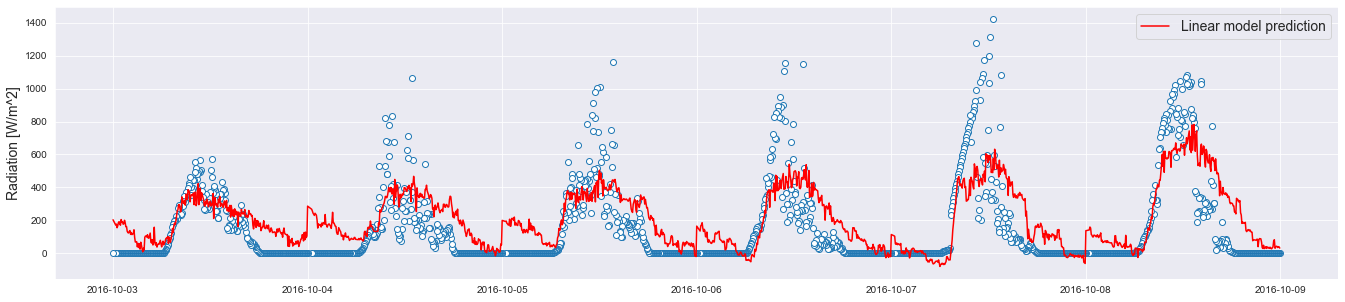

In [30]:
#Carrying out predictions with linear model for the 5-day period
X_five = X.loc['2016-10-03':'2016-10-08',:]
y_five_lr = lr.predict(X_five)


fig, ax = plt.subplots(figsize = (23,5))

ax.plot(data_5.Radiation,'o', markerfacecolor='w')
ax.plot(data_5.index, y_five_lr, linewidth = 1.5, color = 'red', label = 'Linear model prediction')
ax.set_ylabel('Radiation [W/m^2]', fontsize = 14)
ax.legend(fontsize = 14)

plt.show()

# Prediction of the solar radiation with tree-based models
As a more complex class of models to predict the solar radiation, tree-based models are selected. This class of models is characterized by two main advantages:

1.They are capable of capturing non-linear relationships between features and labels

2.They do not require feature scaling (i.e. regularization)

Two models are here selected for prediction: Random Forest and Grandient Boosting. Both models are ensamble methods. This means that they are based on the combination of a set of simple models, which together lead to a more robust and accurate prediction model.

Given that this set of models is more complex than the simple linear regression, some parameters (hyper-parameters) have to be user-specified before the model can be trained. The proper selection of these parameter is of uttermost importance in order to attain a suitable model. This selection process is generally called "hyper-parameter tuning" and it is here carried out by means of a grid-search approach: a list of potential values for the various hyper-parameters is defined and then multiple models are trained as a way to identify the best performing set of hyper-parameters.

The first model to be considered is Random Forest.

In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [38]:
#Initiating Random Forest regressor
rf_model = RandomForestRegressor(random_state = 42)

#Define the grid of hyperparameters
params_rf = {
    'n_estimators': [500, 600, 700],
    'max_depth': [5, 6, 7],
    'min_samples_leaf': [0.075, 0.05, 0.025],
    'max_features': ['log2', 'sqrt']   
}


#Initiate Grid search
grid_rf = GridSearchCV(estimator = rf_model,
                       param_grid = params_rf,
                       cv = 3,
                       scoring = 'neg_mean_squared_error',
                       verbose = 1,
                       n_jobs = -1)

In [39]:
#Fitting the grid search
grid_rf.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:  5.9min finished


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 6, 7],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [0.075, 0.05, 0.025],
                         'n_estimators': [500, 600, 700]},
             scoring='neg_mean_squared_error', verbose=1)

In [40]:
#Extracting best hyperparameters
rf_best_hyperparams = grid_rf.best_params_
print('Best hyperparameters for RF: \n', rf_best_hyperparams)

Best hyperparameters for RF: 
 {'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 0.025, 'n_estimators': 500}


In [41]:
#Extracting best rf model
rf = grid_rf.best_estimator_

In [42]:
#Checking if there is overfitting through the use of Cross validation
rf_MSE_CV = -cross_val_score(rf, X_train, y_train,
                            cv = 10, 
                            scoring = 'neg_mean_squared_error',
                            n_jobs = -1)

In [43]:
#Computing Random Forest predictions in the traning and test sets
rf_predict_train = rf.predict(X_train)
rf_predict_test = rf.predict(X_test)

In [44]:
#Computing the MSE in the traning set, test set, and cross-validation procedure
print('CV MSE for RF:{:.2f}'.format(rf_MSE_CV.mean()))
print('Train MSE for RF:{:.2f}'.format(MSE(y_train,rf_predict_train)))
print('Test MSE for RF:{:.2f}'.format(MSE(y_test,rf_predict_test)))

CV MSE for RF:23167.14
Train MSE for RF:22802.18
Test MSE for RF:23363.53


In [45]:
#Computing the R^2 in the traning set and test set for the Random Forest Regressor
print('Random Forest, R^2 score training set:{:.2f}'.format(r2_score(y_train, rf_predict_train)))
print('Random Forest, R^2 score test set:{:.2f}'.format(r2_score(y_test,rf_predict_test)))

Random Forest, R^2 score training set:0.77
Random Forest, R^2 score test set:0.77


In [46]:
#Initiating Gradient Boosting regressor
gb_model = GradientBoostingRegressor(random_state = 42)

#Define the grid of hyperparameters
params_gb = {
    'n_estimators': [200, 300, 600],
    'max_depth': [2, 3,5],
    'min_samples_leaf': [0.125, 0.1, 0.075],
    'max_features': ['log2', 'sqrt']   
}


#Initiate Grid search
grid_gb = GridSearchCV(estimator = gb_model,
                       param_grid = params_gb,
                       cv = 3,
                       scoring = 'neg_mean_squared_error',
                       verbose = 1,
                       n_jobs = -1)

In [47]:
#Fitting the grid search
grid_gb.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:  3.1min finished


GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [0.125, 0.1, 0.075],
                         'n_estimators': [200, 300, 600]},
             scoring='neg_mean_squared_error', verbose=1)

In [48]:
#Extracting best hyperparameters
gb_best_hyperparams = grid_gb.best_params_
print('Best hyperparameters for GB: \n', gb_best_hyperparams)

Best hyperparameters for GB: 
 {'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 0.075, 'n_estimators': 600}


In [49]:
#Extracting best gb model
gb = grid_gb.best_estimator_

In [50]:
#Checking if there is overfitting through the use of Cross validation
gb_MSE_CV = -cross_val_score(gb, X_train, y_train,
                            cv = 10, 
                            scoring = 'neg_mean_squared_error',
                            n_jobs = -1)

In [51]:
#Computing Gradient Boosting predictions on the train and test stes
gb_predict_train = gb.predict(X_train)
gb_predict_test = gb.predict(X_test)

In [52]:
#GB CV MSE
print('CV MSE for GB:{:.2f}'.format(gb_MSE_CV.mean()))
print('Train MSE for GB:{:.2f}'.format(MSE(y_train,gb_predict_train)))
print('Test MSE for GB:{:.2f}'.format(MSE(y_test,gb_predict_test)))

CV MSE for GB:10462.65
Train MSE for GB:9722.71
Test MSE for GB:10695.07


In [53]:
#Computing the R^2 in the traning set and test set for the Gradient Boosting Regressor
print('Gradient Boosting, R^2 score training set:{:.2f}'.format(r2_score(y_train, gb_predict_train)))
print('Gradient Boosting, R^2 score test set:{:.2f}'.format(r2_score(y_test,gb_predict_test)))

Gradient Boosting, R^2 score training set:0.90
Gradient Boosting, R^2 score test set:0.89


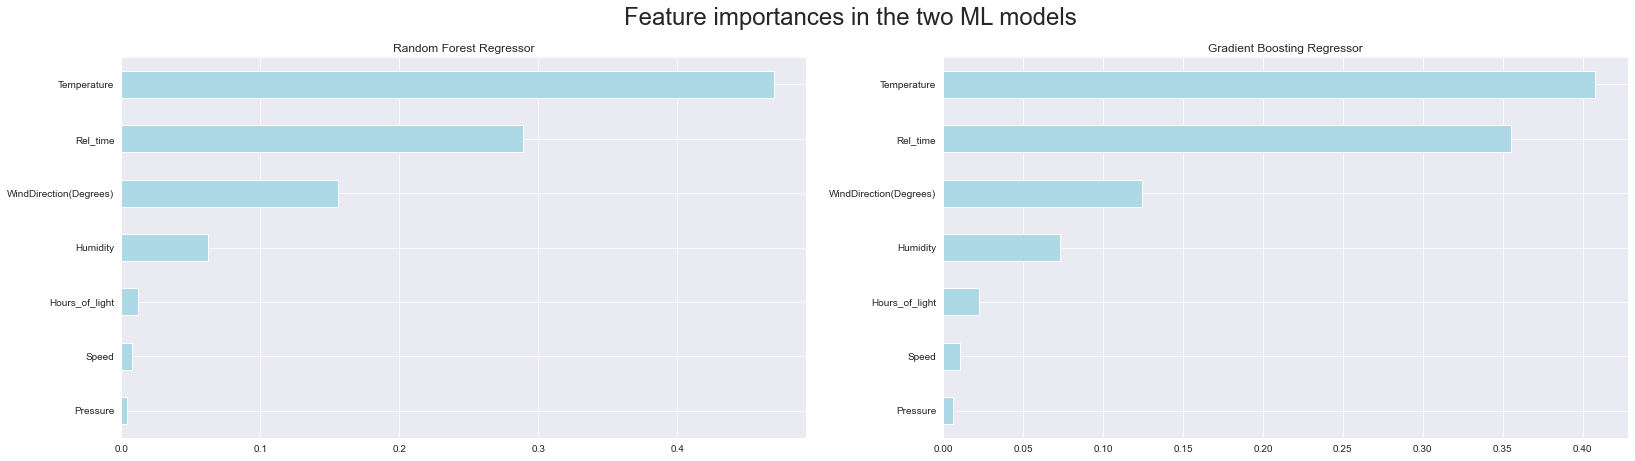

In [54]:
#Plotting feature importances for Random Forest and Gradient boosting

#Creating a pd.Series of feature importances
importances_rf = pd.Series(rf.feature_importances_, index = X.columns)
importances_gb = pd.Series(gb.feature_importances_, index = X.columns)

#Sorting importances
sorted_importances_rf = importances_rf.sort_values()
sorted_importances_gb = importances_gb.sort_values()

#Plotting sorted importances
fig, ax = plt.subplots(ncols = 2, figsize = (27,7))
sorted_importances_rf.plot(kind = 'barh', color = 'lightblue', ax = ax[0])
sorted_importances_gb.plot(kind = 'barh', color = 'lightblue', ax = ax[1])
ax[0].set_title('Random Forest Regressor')
ax[1].set_title('Gradient Boosting Regressor')
fig.suptitle('Feature importances in the two ML models', fontsize = 24)
plt.show()

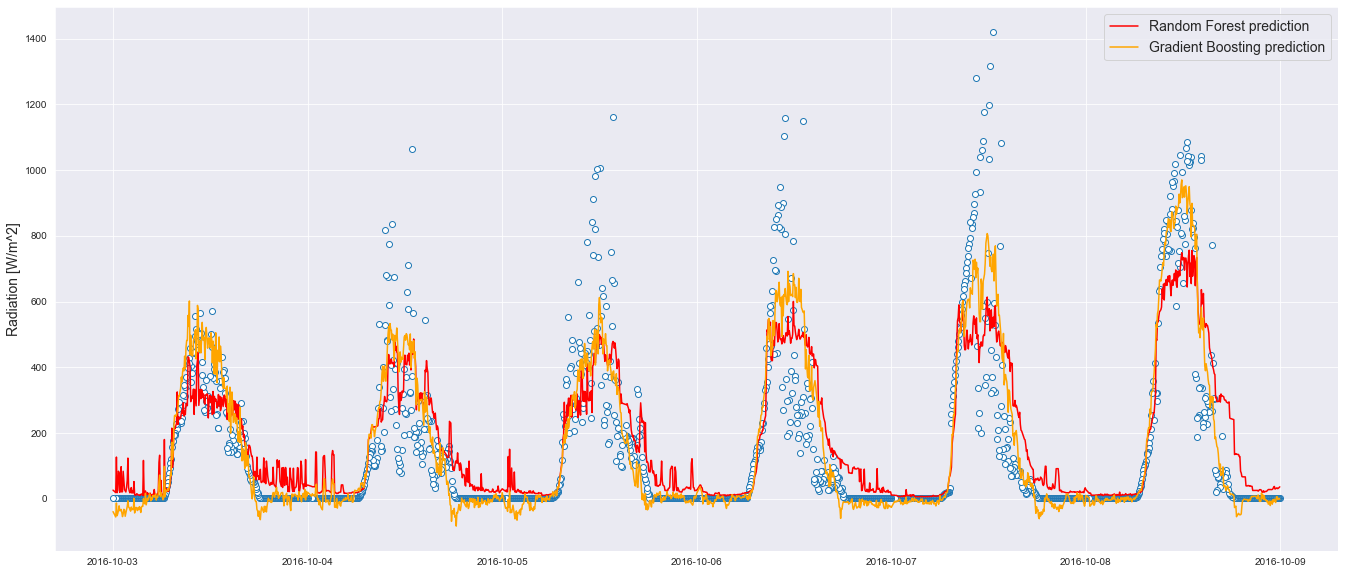

In [55]:
#Computing predictions of the two ML models in the 5-day period
y_five_rf = rf.predict(X_five)
y_five_gb = gb.predict(X_five)

fig, ax = plt.subplots(figsize = (23,10))

ax.plot(data_5.Radiation,'o', markerfacecolor='w')
ax.plot(data_5.index, y_five_rf, linewidth = 1.5, color = 'red', label = 'Random Forest prediction')
ax.plot(data_5.index, y_five_gb, linewidth = 1.5, color = 'orange', label = 'Gradient Boosting prediction')

ax.set_ylabel('Radiation [W/m^2]', fontsize = 14)
ax.legend(fontsize = 14)

plt.show()

The graphical inspection, indicates that the Gradient boosting regressor leads to the most accurate predictions. This could be expected due to the previously shown performance indicators:

R^2 -> 0.9 for Gradient Boosting, and 0.77 for Random Forest
MSE -> 10,000 for Gradient boosting, and 23,000 for Random Forest
Looking at the plots it seems that RF regressor is characterized by the following drawbacks:

It is characterized by high variance in the prediction
It seems to systematically overestimate the solar radiation after the sunset
Both aspects could be improved by refining the hyper-parameter tuning procedure (not all possible parameters were screened).